# 🧠 Hands-On Tutorial: Graph Neural Networks with PyTorch Geometric

Welcome to this hands-on tutorial! In this Colab notebook, you'll learn how to build and train Graph Neural Networks (GNNs) using [PyTorch](https://pytorch.org/) and the [PyTorch Geometric (PyG)](https://pytorch-geometric.readthedocs.io/en/latest/) library.

---

### 📚 References
- [PyTorch Geometric Documentation](https://pytorch-geometric.readthedocs.io/)
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
- [GCN Paper: Semi-Supervised Classification with Graph Convolutional Networks (Kipf & Welling, 2017)](https://arxiv.org/abs/1609.02907)
- [PyG Installation Guide](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

---


In [ ]:
# 🛠️ Install PyG and dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.8 MB/s e

## 📊 1. Create a Simple Graph with PyG

In [ ]:
import torch
from torch_geometric.data import Data

# A simple graph with 3 nodes and 2 undirected edges (0-1 and 1-2)
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[1], [2], [3]], dtype=torch.float)  # Node features

data = Data(x=x, edge_index=edge_index)
print(data)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Data(x=[3, 1], edge_index=[2, 4])


## 🧠 2. Define a GCN Layer Model

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


## 📂 3. Load the Cora Dataset

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(data)
print(f"Node feature shape: {data.x.shape}")
print(f"Number of classes: {dataset.num_classes}")


Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature shape: torch.Size([2708, 1433])
Number of classes: 7


Done!


## 🏋️ 4. Train the GCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        acc = (pred[mask] == data.y[mask]).sum() / mask.sum()
        accs.append(acc.item())
    return accs

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.2f}, Val: {val_acc:.2f}, Test: {test_acc:.2f}')


Epoch 010, Loss: 0.6806, Train: 0.97, Val: 0.75, Test: 0.77
Epoch 020, Loss: 0.1261, Train: 1.00, Val: 0.78, Test: 0.80
Epoch 030, Loss: 0.0313, Train: 1.00, Val: 0.78, Test: 0.79
Epoch 040, Loss: 0.0156, Train: 1.00, Val: 0.78, Test: 0.79
Epoch 050, Loss: 0.0131, Train: 1.00, Val: 0.78, Test: 0.80
Epoch 060, Loss: 0.0142, Train: 1.00, Val: 0.78, Test: 0.80
Epoch 070, Loss: 0.0160, Train: 1.00, Val: 0.78, Test: 0.80
Epoch 080, Loss: 0.0167, Train: 1.00, Val: 0.79, Test: 0.80
Epoch 090, Loss: 0.0165, Train: 1.00, Val: 0.79, Test: 0.81
Epoch 100, Loss: 0.0157, Train: 1.00, Val: 0.78, Test: 0.81
Epoch 110, Loss: 0.0148, Train: 1.00, Val: 0.78, Test: 0.81
Epoch 120, Loss: 0.0140, Train: 1.00, Val: 0.78, Test: 0.81
Epoch 130, Loss: 0.0133, Train: 1.00, Val: 0.78, Test: 0.81
Epoch 140, Loss: 0.0127, Train: 1.00, Val: 0.78, Test: 0.81
Epoch 150, Loss: 0.0122, Train: 1.00, Val: 0.78, Test: 0.81
Epoch 160, Loss: 0.0117, Train: 1.00, Val: 0.78, Test: 0.81
Epoch 170, Loss: 0.0113, Train: 1.00, Va

## 📈 5. Visualise Node Embeddings (Optional)


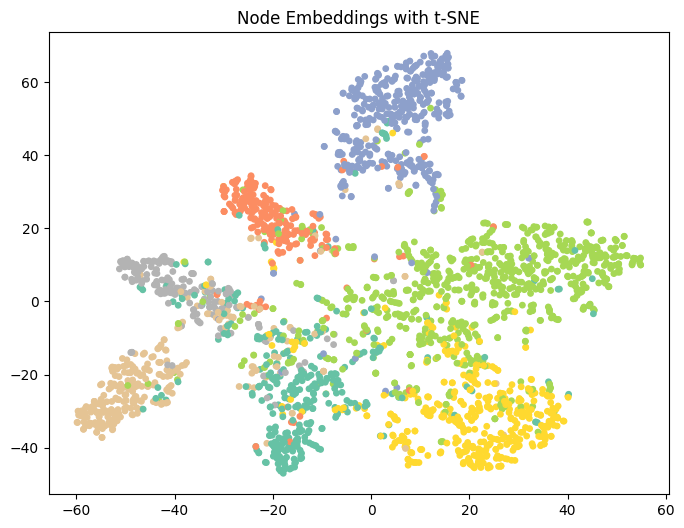

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model.eval()
out = model(data.x, data.edge_index)
z = out.detach().cpu()

tsne = TSNE(n_components=2)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=data.y.cpu(), cmap='Set2', s=15)
plt.title("Node Embeddings with t-SNE")
plt.show()


## 🕸️ 6. Visualise the graph (Optional)

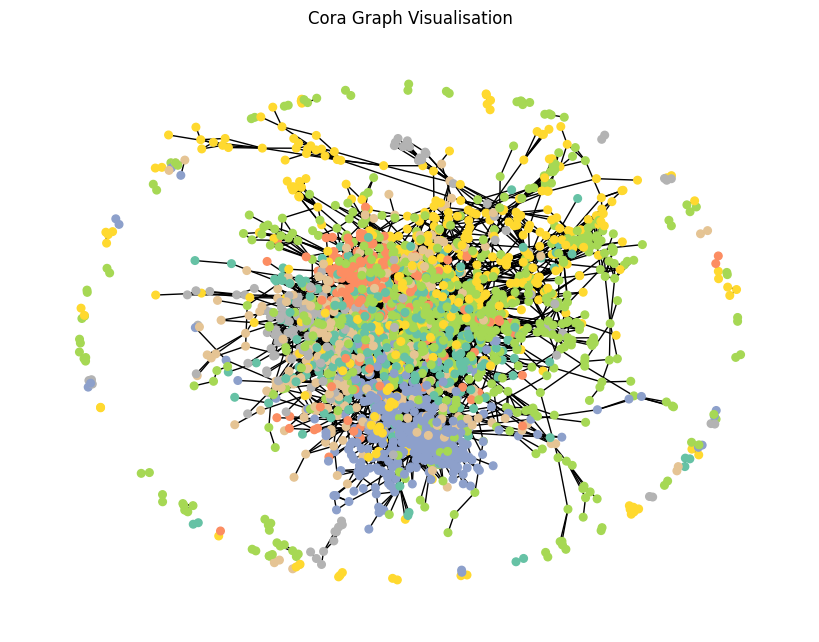

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG Data object to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=False, node_color=data.y.cpu(), cmap=plt.cm.Set2, node_size=30)
plt.title("Cora Graph Visualisation")
plt.show()


## ✅ Next Steps

- Try different GNN layers like `SAGEConv`, `GATConv`, etc.
- Apply GNNs to your own datasets using `torch_geometric.data.Data`
- Learn batching and multiple graphs with `DataLoader`

---

### 🔗 Additional Resources

- PyG Tutorials: [https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)
- Cora Dataset: [https://linqs.soe.ucsc.edu/data](https://linqs.soe.ucsc.edu/data)

---

### 📚 Other Packages for GNNs
- [Spektral](https://graphneural.network/)
- [DGL](https://www.dgl.ai/)
